# Final Project Submission

Please fill out:
* Student name: **Brian Bentson**
* Student pace: self paced / part time / full time: **Full Time**
* Scheduled project review date/time: 
* Instructor name: **James Irving**
* Blog post URL:
* Video of 5-min Non-Technical Presentation:

# Table of Contents

*Click to jump to matching Markdown Header.*<br><br>
 
- **[INTRODUCTION](#Introduction)<br>**
- **[OBTAIN](#Obtain)**<br>
- **[SCRUB](#Scrub)**<br>
- **[EXPLORE](#Explore)**<br>
- **[MODEL](#Model)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
___

# Introduction

## Business Statement

Most people's largest asset is their home which acts as the foundation for their net worth. Therefore, it is imperative that the value of this asset improves over time through either property value inflation or smart renovations. Since property values are largely based on location and current market conditions, which are outside of your control, renovations are the only controllable factor when trying to improve a homes value. In this analysis, I will explore which factors in a house are most correlated to higher value by looking at historical sales of homes in King County, Washington.

## Analysis Methodology

I will be analyzing historic home sales from King County, Washington in order to see which factors affect home price and how a model can be built to predict good estimates for home listing prices. This model will give insights into what a current home owner could do in order to improve their home value. I will focus only on features which a home owner has control over and eliminate the others.

# Obtain

## Import Packages

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
plt.style.use('fivethirtyeight')

import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
import statsmodels.stats.api as sms
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [50]:
pd.set_option("display.max_columns", 30)
pd.options.display.float_format = '{:,}'.format

## Global Functions

In [51]:
#function to look at plots and stats of column with or without outliers
def get_plots(df, x_col, y_col='price', outlier='std'):
    
    """This function takes in a dataframe and a column, removes outliers using
       standard deviations or iqr and produces a histogram, scatter plot and
       boxplot of the values with descriptive statistics"""
    
    #plots for std
    if outlier == 'std':
        #create variables
        col_mean = df[x_col].mean()
        col_std = df[x_col].std()
        upper_thresh_std = col_mean + 3*col_std
        lower_thresh_std = col_mean - 3*col_std
        
        #create new df
        idx_std_outliers = (df[x_col] > lower_thresh_std) & (df[x_col] < upper_thresh_std)
        std_df = df.loc[idx_std_outliers]
        
        #plots
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10));
        histogram = std_df[x_col].hist(ax=ax[0,0]);
        ax[0,0].set_title(f'Distribution of {x_col}');

        scatter = std_df.plot(kind='scatter', x=x_col, y=y_col,ax=ax[0,1]);
        ax[0,1].set_title(f'{y_col} vs {x_col}');

        boxplot = std_df.boxplot(column=x_col, ax=ax[1,0]);
        ax[1,0].set_title(f'Boxplot of {x_col}');
        
        sm.graphics.qqplot(std_df[x_col], dist=stats.norm, line='45', fit=True, ax=ax[1,1])
        ax[1,1].set_title(f'QQ plot of {x_col}');
        
        #stats
        rows_removed = len(df) - len(std_df)
        print(f'The number of rows removed is {rows_removed}')
        desc_stats = std_df[x_col].describe()
        plt.tight_layout()
        
    elif outlier == 'iqr':
        #create variables
        q25 = df[x_col].quantile(0.25)
        q75 = df[x_col].quantile(0.75)
        iqr = q75-q25
        upper_thresh_iqr = q75 + 1.5*iqr
        lower_thresh_iqr = q25 - 1.5*iqr
        
        #create new df
        idx_iqr_outliers = (df[x_col] > lower_thresh_iqr) & (df[x_col] < upper_thresh_iqr)
        iqr_df = df.loc[idx_iqr_outliers]
        
        #plots
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10));
        histogram = iqr_df[x_col].hist(ax=ax[0,0]);
        ax[0,0].set_title(f'Distribution of {x_col}');

        scatter = iqr_df.plot(kind='scatter', x=x_col, y=y_col,ax=ax[0,1]);
        ax[0,1].set_title(f'{y_col} vs {x_col}');

        boxplot = iqr_df.boxplot(column=x_col, ax=ax[1,0]);
        ax[1,0].set_title(f'Boxplot of {x_col}');
        
        sm.graphics.qqplot(iqr_df[x_col], dist=stats.norm, line='45', fit=True, ax=ax[1,1])
        ax[1,1].set_title(f'QQ plot of {x_col}');
        
        #stats
        rows_removed = len(df) - len(iqr_df)
        print(f'The number of rows removed is {rows_removed}')
        desc_stats = df[x_col].describe()
        plt.tight_layout()
    
    elif outlier == 'none':
        #plots
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10));
        histogram = df[x_col].hist(ax=ax[0,0]);
        ax[0,0].set_title(f'Distribution of {x_col}');

        scatter = df.plot(kind='scatter', x=x_col, y=y_col,ax=ax[0,1]);
        ax[0,1].set_title(f'{y_col} vs {x_col}');

        boxplot = df.boxplot(column=x_col, ax=ax[1,0]);
        ax[1,0].set_title(f'Boxplot of {x_col}');

        sm.graphics.qqplot(df[x_col], dist=stats.norm, line='45', fit=True, ax=ax[1,1])
        ax[1,1].set_title(f'QQ plot of {x_col}');
        
        #stats
        desc_stats = df[x_col].describe()
        plt.tight_layout()

        
    print(desc_stats)
    plt.show()
    
    return
#     return histogram, scatter, boxplot, desc_stats, idx_iqr_outliers

In [52]:
#function to preprocess and create a new model
def fit_new_model(df, x_cols=None, y_col=None, norm=False, diagnose=True):
    '''This function takes in a dataframe, a list of independent and dependent
       variables and whether or not you want to normalize the columns. The 
       output is a multiple linear regression model with checks for 
       multicollinearity, normality and homoscedasticity.'''
         
    #step 1: normalize columns
    if norm == True:
        for col in x_cols:
            df[col] = (df[col] - df[col].mean())/df[col].std()
        #display the normalized df
        display(df.head())
        print('\n')
    else:
        #display the df
        display(df.head())
        print('\n')
    
    #step 2: create model
    
    #set up model parameters
    x_cols = x_cols
    outcome = y_col
    predictors = '+'.join(x_cols)
    formula = outcome + '~' + predictors
    #fit the model
    model = ols(formula=formula, data=df).fit()
    print(model.summary())
    print('\n')
    
    #step 3: check multicollinearity
    print('VIF Multicollinearity Test Results')
    print('======================================================================================================')
    #run VIF test
    X = df[x_cols]
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    display(list(zip(x_cols, vif)))
    print('\n')
    
    #step 4: check normality
    print('Normality Test Results')
    print('======================================================================================================')
    #plot qqplot
    fig, ax = plt.subplots(figsize=(15,10))
    sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True, ax=ax);
    ax.set_title('QQPlot for Model Residuals')
    plt.show()
    print('\n')
    
    #step 5: check homoscedasticity
    print('Homoscedasticity Test Results')
    print('======================================================================================================')
    #scatter plot
    fig, ax = plt.subplots(figsize=(15,10))
    plt.scatter(model.predict(df[x_cols]), model.resid)
    plt.plot(model.predict(df[x_cols]), [0 for i in range(len(df))])
    ax.set_title('Model Residuals vs Model Predictions')
    plt.show()
    return model

In [53]:
#function to delete outliers using either iqr or std
def outliers(df, col, outlier='std'):
    '''This function takes in a dataframe, a column in the dataframe and 
       whether or not to remove outliers via standard deviations or
       interquartile range.'''
        
    if outlier == 'std':
        #create outlier variables
        col_mean = df[col].mean()
        col_std = df[col].std()
        upper_thresh_std = col_mean + 3*col_std
        lower_thresh_std = col_mean - 3*col_std
        #update dataframe
        df_new = df.loc[(df[col] > lower_thresh_std) & (df[col] < upper_thresh_std)]
        print(f'There were {len(df) - len(df_new)} outliers removed.')
    elif outlier == 'iqr':
        #create outlier variables
        q25 = df[col].quantile(0.25)
        q75 = df[col].quantile(0.75)
        iqr = q75-q25
        upper_thresh_iqr = q75 + 1.5*iqr
        lower_thresh_iqr = q25 - 1.5*iqr
        #create new dataframe with outliers removed
        df_new = df.loc[(df[col] > lower_thresh_iqr) & (df[col] < upper_thresh_iqr)]
        print(f'There were {len(df) - len(df_new)} outliers removed.')

    return df_new

## Import Data into Pandas

I will be importing a csv dataset which provides me with the information necessary to begin the analysis.

In [54]:
#import the dataset from local csv
df_original = pd.read_csv('Data/kc_house_data.csv')
df_original

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,"221,900.0",3,1.0,1180,5650,1.0,nan,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,"1,991.0",98125,47.721000000000004,-122.319,1690,7639
2,5631500400,2/25/2015,"180,000.0",2,1.0,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,nan,98028,47.7379,-122.23299999999999,2720,8062
3,2487200875,12/9/2014,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.39299999999999,1360,5000
4,1954400510,2/18/2015,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,"360,000.0",3,2.5,1530,1131,3.0,0.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,"400,000.0",4,2.5,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.36200000000001,1830,7200
21594,1523300141,6/23/2014,"402,101.0",2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.29899999999999,1020,2007
21595,291310100,1/16/2015,"400,000.0",3,2.5,1600,2388,2.0,nan,0.0,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


## Data Schema

**Taken from https://rstudio-pubs-static.s3.amazonaws.com/155304_cc51f448116744069664b35e7762999f.html**

**Bolded features are owner controlled in a potential renovation**

id - Unique ID for each home sold 

date - Date of the home sale 

price - Price of each home sold 

**bedrooms - Number of bedrooms**

**bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower**

**sqft_living - Square footage of the apartments interior living space**

sqft_lot - Square footage of the land space 

**floors - Number of floors**

waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not 

**view - An index from 0 to 4 of how good the view of the property was**

**condition - An index from 1 to 5 on the condition of the apartment**

**grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.**

**sqft_above - The square footage of the interior housing space that is above ground level**

**sqft_basement - The square footage of the interior housing space that is below ground level**

yr_built - The year the house was initially built 

**yr_renovated - The year of the house’s last renovation**

zipcode - What zipcode area the house is in 

lat - Lattitude 

long - Longitude 

sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors 

sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors 

## Investigate Data

I will preliminarily investigate the data to identify any glaring issues to fix later.

In [55]:
#column names
df_original.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [56]:
#view df info to inspect data types
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

> **Observations on Data**
> - `waterfront` values should be updated to categorical
> - `yr_renovated` values should be updated to categorical
> - `sqft_basement` data type should be changed to integer

In [57]:
#check for null values
df_original.isna().sum()/len(df_original)*100

id                              0.0
date                            0.0
price                           0.0
bedrooms                        0.0
bathrooms                       0.0
sqft_living                     0.0
sqft_lot                        0.0
floors                          0.0
waterfront        11.00152798999861
view            0.29170718155299347
condition                       0.0
grade                           0.0
sqft_above                      0.0
sqft_basement                   0.0
yr_built                        0.0
yr_renovated      17.78950780200954
zipcode                         0.0
lat                             0.0
long                            0.0
sqft_living15                   0.0
sqft_lot15                      0.0
dtype: float64

> **Observations on Data**
> - `waterfront` has 11% null values which may be dropped
> - `view` should be inspected for a potential column drop
> - `yr_renovated` has 18% null values which may be dropped
> - All other columns have 0 nulls

In [58]:
#check numeric data
df_original.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,"21,597.0","21,597.0","21,597.0","21,597.0","21,597.0","21,597.0","21,597.0","19,221.0","21,534.0","21,597.0","21,597.0","21,597.0","21,597.0","17,755.0","21,597.0","21,597.0","21,597.0","21,597.0","21,597.0"
mean,"4,580,474,287.770987","540,296.5735055795",3.3731999814789093,2.1158262721674306,"2,080.3218502569803","15,099.408760475992",1.4940964022780943,0.007595858696217679,0.23386272870808952,3.4098254387183404,7.657915451220076,"1,788.5968421540028","1,970.9996758809093",83.6367783722895,"98,077.95184516368",47.56009299439737,-122.2139824975691,"1,986.6203176367087","12,758.283511598833"
std,"2,876,735,715.74778","367,368.1401013945",0.9262988945421479,0.7689842966527209,918.1061250800805,"41,412.636875502074",0.5396827909775457,0.08682484570054606,0.7656862011746727,0.6505456356725546,1.1731996637760254,827.7597611646754,29.375234132441644,399.9464138788162,53.51307235352816,0.13855176817307177,0.14072352882947373,685.2304719001586,"27,274.441950386343"
min,"1,000,102.0","78,000.0",1.0,0.5,370.0,520.0,1.0,0.0,0.0,1.0,3.0,370.0,"1,900.0",0.0,"98,001.0",47.1559,-122.51899999999999,399.0,651.0
25%,"2,123,049,175.0","322,000.0",3.0,1.75,"1,430.0","5,040.0",1.0,0.0,0.0,3.0,7.0,"1,190.0","1,951.0",0.0,"98,033.0",47.4711,-122.32799999999999,"1,490.0","5,100.0"
50%,"3,904,930,410.0","450,000.0",3.0,2.25,"1,910.0","7,618.0",1.5,0.0,0.0,3.0,7.0,"1,560.0","1,975.0",0.0,"98,065.0",47.5718,-122.23100000000001,"1,840.0","7,620.0"
75%,"7,308,900,490.0","645,000.0",4.0,2.5,"2,550.0","10,685.0",2.0,0.0,0.0,4.0,8.0,"2,210.0","1,997.0",0.0,"98,118.0",47.678000000000004,-122.125,"2,360.0","10,083.0"
max,"9,900,000,190.0","7,700,000.0",33.0,8.0,"13,540.0","1,651,359.0",3.5,1.0,4.0,5.0,13.0,"9,410.0","2,015.0","2,015.0","98,199.0",47.7776,-121.315,"6,210.0","871,200.0"


# Scrub

I will make a new dataframe which is a copy of the `df_original` dataframe to begin making changes. 

In [59]:
#create a copy of the original dataframe
df_scrub = df_original.copy()
df_scrub

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,"221,900.0",3,1.0,1180,5650,1.0,nan,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,"1,991.0",98125,47.721000000000004,-122.319,1690,7639
2,5631500400,2/25/2015,"180,000.0",2,1.0,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,nan,98028,47.7379,-122.23299999999999,2720,8062
3,2487200875,12/9/2014,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.39299999999999,1360,5000
4,1954400510,2/18/2015,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,"360,000.0",3,2.5,1530,1131,3.0,0.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,"400,000.0",4,2.5,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.36200000000001,1830,7200
21594,1523300141,6/23/2014,"402,101.0",2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.29899999999999,1020,2007
21595,291310100,1/16/2015,"400,000.0",3,2.5,1600,2388,2.0,nan,0.0,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


## Feature Engineering

### Basement Column

In the dataset we have 3 related columns:
- `sqft_above`
- `sqft_basement`
- `sqft_living`

These columns are related in that `sqft_living` equals `sqft_above` plus `sqft_basement`. I do not think the square footage of the basement is as important as just knowing that a house has one. Therefore, I will create a new column which shows whether or not a house has a basement.

In [60]:
#investigate values in sqft_basement
df_scrub['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
20.0          1
2500.0        1
417.0         1
2310.0        1
2050.0        1
Name: sqft_basement, Length: 304, dtype: int64

> **ACTION: '?' impedes the ability to create a new column. Will drop the 454 rows, which is 2% of the data**

In [61]:
#drop rows with '?' value in sqft_basement column
df_scrub.drop(df_scrub.loc[df_scrub['sqft_basement'] == '?'].index,inplace=True)
print(f'The dataframe now has {len(df_scrub)} many rows.')

The dataframe now has 21143 many rows.


In [62]:
#prove that these columns are related
df_scrub['sqft_basement'] = df_scrub['sqft_basement'].astype(float).astype(int)
sqft = df_scrub[['sqft_living', 'sqft_above', 'sqft_basement']]
df_scrub['sqft_basement'].dtype
(sqft['sqft_above'] + sqft['sqft_basement'] == sqft['sqft_living']).value_counts()

True    21143
dtype: int64

In [63]:
#check the rows have been dropped
df_scrub.loc[df_original['sqft_basement'] == '?']['sqft_basement'].count()

0

> **ACTIONS**
> - Will now create new column named `basement` which represents whether or not a house has a basement.

In [64]:
#create new column for basement
df_scrub['basement'] = np.where(df_scrub['sqft_basement'] > 0, 1,0)
df_scrub

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement
0,7129300520,10/13/2014,"221,900.0",3,1.0,1180,5650,1.0,nan,0.0,3,7,1180,0,1955,0.0,98178,47.5112,-122.257,1340,5650,0
1,6414100192,12/9/2014,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400,1951,"1,991.0",98125,47.721000000000004,-122.319,1690,7639,1
2,5631500400,2/25/2015,"180,000.0",2,1.0,770,10000,1.0,0.0,0.0,3,6,770,0,1933,nan,98028,47.7379,-122.23299999999999,2720,8062,0
3,2487200875,12/9/2014,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1050,910,1965,0.0,98136,47.5208,-122.39299999999999,1360,5000,1
4,1954400510,2/18/2015,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,1680,0,1987,0.0,98074,47.6168,-122.045,1800,7503,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,"360,000.0",3,2.5,1530,1131,3.0,0.0,0.0,3,8,1530,0,2009,0.0,98103,47.6993,-122.346,1530,1509,0
21593,6600060120,2/23/2015,"400,000.0",4,2.5,2310,5813,2.0,0.0,0.0,3,8,2310,0,2014,0.0,98146,47.5107,-122.36200000000001,1830,7200,0
21594,1523300141,6/23/2014,"402,101.0",2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0,2009,0.0,98144,47.5944,-122.29899999999999,1020,2007,0
21595,291310100,1/16/2015,"400,000.0",3,2.5,1600,2388,2.0,nan,0.0,3,8,1600,0,2004,0.0,98027,47.5345,-122.069,1410,1287,0


### Renovated Column

I want to reconfigure the `yr_renovated` column so that it is compatible with the model. I will drop null rows and create a new column which indicates whether or not a house has been renovated.

In [65]:
#check values in yr_renovated column
df_scrub['yr_renovated'].value_counts(dropna=False).head(20)

0.0        16666
nan         3754
2,014.0       69
2,013.0       31
2,003.0       31
2,007.0       30
2,000.0       29
2,005.0       29
1,990.0       22
2,009.0       21
2,004.0       21
2,006.0       20
1,989.0       18
2,002.0       17
2,008.0       15
1,998.0       15
1,999.0       15
1,983.0       15
1,984.0       15
1,987.0       14
Name: yr_renovated, dtype: int64

> **ACTION: I will remove the 3,330 null rows**

In [66]:
#remove null values from yr_renovated
df_scrub.dropna(subset=['yr_renovated'], inplace=True)
df_scrub['yr_renovated'].value_counts(dropna=False)

0.0        16666
2,014.0       69
2,003.0       31
2,013.0       31
2,007.0       30
           ...  
1,953.0        1
1,944.0        1
1,934.0        1
1,971.0        1
1,959.0        1
Name: yr_renovated, Length: 69, dtype: int64

> **ACTION: Create new `renovated` column which gives a 0 if false and 1 if true**

In [67]:
#create new column based on yr_renovated
df_scrub['renovated'] = np.where(df_scrub['yr_renovated'] == 0, 0, 1)
df_scrub[['yr_renovated','renovated']]

,yr_renovated,renovated
0,0.0,0
1,"1,991.0",1
3,0.0,0
4,0.0,0
5,0.0,0
...,...,...
21592,0.0,0
21593,0.0,0
21594,0.0,0
21595,0.0,0


## Change Data Types

In [68]:
#check data types
df_scrub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17389 entries, 0 to 21596
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             17389 non-null  int64  
 1   date           17389 non-null  object 
 2   price          17389 non-null  float64
 3   bedrooms       17389 non-null  int64  
 4   bathrooms      17389 non-null  float64
 5   sqft_living    17389 non-null  int64  
 6   sqft_lot       17389 non-null  int64  
 7   floors         17389 non-null  float64
 8   waterfront     15474 non-null  float64
 9   view           17340 non-null  float64
 10  condition      17389 non-null  int64  
 11  grade          17389 non-null  int64  
 12  sqft_above     17389 non-null  int64  
 13  sqft_basement  17389 non-null  int64  
 14  yr_built       17389 non-null  int64  
 15  yr_renovated   17389 non-null  float64
 16  zipcode        17389 non-null  int64  
 17  lat            17389 non-null  float64
 18  long  

## Null Values

In [69]:
#check for null values
df_scrub.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       1915
view               49
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated        0
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
basement            0
renovated           0
dtype: int64

### `waterfront` Column

In [70]:
#view values in waterfront column
df_scrub['waterfront'].value_counts(dropna=False)

0.0    15357
nan     1915
1.0      117
Name: waterfront, dtype: int64

> **OBSERVATIONS:**
> - `waterfront` has 11% null values.

> **ACTION**
> - I will explore how I can fill the nulls in the `waterfront` values

In [71]:
#correlation of waterfront
df_scrub.corr()['waterfront']

id              0.00025701287504176993
price               0.2822770948170352
bedrooms        -0.0010807514336662167
bathrooms          0.07002178441901094
sqft_living        0.11649875240644571
sqft_lot          0.025385694196076926
floors             0.01821976032702285
waterfront                         1.0
view               0.40725992880117945
condition         0.017090301729900097
grade              0.08593714755629313
sqft_above         0.07997648285568942
sqft_basement      0.09212792372004248
yr_built         -0.022434269901402182
yr_renovated       0.08326974566746399
zipcode           0.028560804093605768
lat              -0.014982528490386579
long              -0.04034577150059966
sqft_living15      0.09416738570266123
sqft_lot15         0.02917024013318345
basement           0.04268581043019616
renovated          0.08366555989807102
Name: waterfront, dtype: float64

> **OBSERVATIONS**
> - `waterfront` correlates most closely with `view` at a coefficient of 0.40

> **ACTIONS**
> - I will determine how i can utilize the `view` column to fill out the nulls in the `waterfall` column

In [72]:
#number of waterfront properties in each view category
df_scrub.groupby('view')['waterfront'].sum()

view
0.0    0.0
1.0    1.0
2.0    6.0
3.0   10.0
4.0   99.0
Name: waterfront, dtype: float64

> **OBSERVATIONS**
> - It seems that most of the waterfront homes also have a view ranking of 3 or 4

In [73]:
#there are 19 null values in waterfront with a view of 4
df_scrub.loc[(df_scrub['waterfront'].isna()) & (df_scrub['view'] == 4)].head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement,renovated
582,2998800125,7/1/2014,"730,000.0",2,2.25,2130,4920,1.5,nan,4.0,4,7,1530,600,1941,0.0,98116,47.573,-122.40899999999999,2130,4920,1,0
1732,913000340,1/2/2015,"252,000.0",1,1.0,680,1638,1.0,nan,4.0,1,6,680,0,1910,"1,992.0",98116,47.5832,-122.399,1010,3621,0,1
2563,7856400240,2/11/2015,"1,650,000.0",4,3.0,3900,9750,1.0,nan,4.0,5,10,2520,1380,1972,0.0,98006,47.5605,-122.15799999999999,3410,9450,1,0
3825,8550001515,10/1/2014,"429,592.0",2,2.75,1992,10946,1.5,nan,4.0,5,6,1288,704,1903,0.0,98070,47.3551,-122.475,1110,8328,1,0
4422,7781600100,9/5/2014,"1,340,000.0",3,2.75,2730,38869,1.5,nan,4.0,3,9,1940,790,1963,"2,001.0",98146,47.4857,-122.361,2630,28188,1,1


In [74]:
#there are 54 null values in waterfront with a view of 3
df_scrub.loc[(df_scrub['waterfront'].isna()) & (df_scrub['view'] == 3)].head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement,renovated
60,1516000055,12/10/2014,"650,000.0",3,2.25,2150,21235,1.0,nan,3.0,4,8,1590,560,1959,0.0,98166,47.4336,-122.339,2570,18900,1,0
216,46100204,2/21/2015,"1,510,000.0",5,3.0,3300,33474,1.0,nan,3.0,3,9,1870,1430,1957,"1,991.0",98040,47.5673,-122.21,3836,20953,1,1
527,3225079035,6/18/2014,"1,600,000.0",6,5.0,6050,230652,2.0,nan,3.0,3,11,6050,0,2001,0.0,98024,47.6033,-121.943,4210,233971,0,0
707,4022907770,10/14/2014,"550,000.0",4,1.75,2480,14782,1.0,nan,3.0,3,8,1460,1020,1958,0.0,98155,47.7646,-122.271,2910,10800,1,0
830,2061100570,2/10/2015,"595,000.0",3,1.75,1910,5753,1.0,nan,3.0,3,8,1110,800,1941,0.0,98115,47.6898,-122.32700000000001,1630,5580,1,0


> **ACTIONS**
> - Fill in the null waterfront value when the view is 3 or 4

In [75]:
#fill in null where view is 4
df_scrub.loc[(df_scrub['waterfront'].isna()) & (df_scrub['view'] == 4),['waterfront']] = 1

In [76]:
#fill in null where view is 3
df_scrub.loc[(df_scrub['waterfront'].isna()) & (df_scrub['view'] == 3),['waterfront']] = 1

In [77]:
#check the changes
df_scrub.loc[(df_scrub['waterfront'].isna()) & (df_scrub['view'] == 4)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement,renovated


In [78]:
#check the changes
df_scrub.loc[(df_scrub['waterfront'].isna()) & (df_scrub['view'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement,renovated


In [79]:
#view values in waterfront column
df_scrub['waterfront'].value_counts(dropna=False)/len(df_scrub)

0.0      0.883144516648456
nan    0.10592903559721663
1.0   0.010926447754327448
Name: waterfront, dtype: float64

>**OBSERVATIONS**
> - The number of nulls in the `waterfront` column is still 10.5%

>**ACTIONS**
> - I will convert the rest of the nulls to zeros as they do not seem to have any other indicators of being a waterfront property

In [80]:
#convert waterfront null values to 0
df_scrub.loc[df_scrub['waterfront'].isna(),['waterfront']] = 0

In [81]:
#check waterfront values
df_scrub['waterfront'].value_counts(dropna=False)

0.0    17199
1.0      190
Name: waterfront, dtype: int64

In [82]:
print(f'The dataframe now has {len(df_scrub)} many rows.')

The dataframe now has 17389 many rows.


### `view` Column

In [83]:
#view the values of the view column
df_scrub['view'].value_counts(dropna=False)

0.0    15649
2.0      770
3.0      393
1.0      274
4.0      254
nan       49
Name: view, dtype: int64

> **ACTION:**
> - I will drop the 39 null values

In [84]:
#drop rows
df_scrub.dropna(subset=['view'], inplace=True)
df_scrub['view'].isna().sum()

0

In [85]:
#check the view column
df_scrub['view'].value_counts(dropna=False)

0.0    15649
2.0      770
3.0      393
1.0      274
4.0      254
Name: view, dtype: int64

In [86]:
#recheck null values in dataframe
df_scrub.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
basement         0
renovated        0
dtype: int64

## Duplicates

### Duplicates for `id`

In [87]:
#check for duplicates
duplicate_id = df_scrub.loc[df_scrub.duplicated(subset='id', keep=False) == True].sort_values('id').head(50)
duplicate_id.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement,renovated
2494,1000102,9/16/2014,"280,000.0",6,3.0,2400,9373,2.0,0.0,0.0,3,7,2400,0,1991,0.0,98002,47.3262,-122.214,2060,7316,0,0
2495,1000102,4/22/2015,"300,000.0",6,3.0,2400,9373,2.0,0.0,0.0,3,7,2400,0,1991,0.0,98002,47.3262,-122.214,2060,7316,0,0
11422,109200390,10/20/2014,"250,000.0",3,1.75,1480,3900,1.0,0.0,0.0,4,7,1480,0,1980,0.0,98023,47.2977,-122.367,1830,6956,0,0
11421,109200390,8/20/2014,"245,000.0",3,1.75,1480,3900,1.0,0.0,0.0,4,7,1480,0,1980,0.0,98023,47.2977,-122.367,1830,6956,0,0
7785,251300110,7/31/2014,"225,000.0",3,2.25,2510,12013,2.0,0.0,0.0,3,8,2510,0,1988,0.0,98003,47.3473,-122.314,1870,8017,0,0


In [88]:
#check duplicates
df_scrub.loc[df_scrub['id'] == 4139480200]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement,renovated
313,4139480200,6/18/2014,"1,380,000.0",4,3.25,4290,12103,1.0,0.0,3.0,3,11,2690,1600,1997,0.0,98006,47.5503,-122.102,3860,11244,1,0
314,4139480200,12/9/2014,"1,400,000.0",4,3.25,4290,12103,1.0,0.0,3.0,3,11,2690,1600,1997,0.0,98006,47.5503,-122.102,3860,11244,1,0


> **OBSERVATOINS**
> - Duplicates in the `id` column seem to represent multiple sales of the same house. I will remove them because they aren't many and I am not sure how they will impact the model's prediction.

In [89]:
#remove duplicates
df_scrub.drop(duplicate_id.index, inplace=True)

## Column Drop

In [90]:
#look at columns
df_scrub.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'basement', 'renovated'],
      dtype='object')

### The `sqft_basement` Column

The `sqft_basement` column can be eliminated now that I have a column which represents whether or not a house has a basement.

In [91]:
#drop the sqft_basement column
df_scrub.drop(columns='sqft_basement', inplace=True)
df_scrub.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'basement', 'renovated'],
      dtype='object')

### The `sqft_living15` and `sqft_lot15` Columns

The `sqft_living15` and `sqft_lot15` columns do not seem to be relevant for predicting home listing prices. I will remove these.

In [92]:
#drop columns
df_scrub.drop(columns=['sqft_living15','sqft_lot15'], inplace=True)
df_scrub.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'basement', 'renovated'],
      dtype='object')

### `yr_renovated` Column

In [93]:
#drop the yr_renovated column
df_scrub.drop(columns='yr_renovated', inplace=True)

### `yr_built` Column

I will be removing `yr_built` as it is related to the new column I created named `home_age`

In [94]:
#drop the yr_built column
df_scrub.drop(columns='yr_built', inplace=True)

### `id` Column

I will be removing the `id` column as I do not want the model to confuse the meaning of this unique identifier.

In [95]:
#drop the id column
df_scrub.drop(columns='id', inplace=True)

### `date` Column

The `date` column represents the sale date which I do not think is relevant to the model's output since it is a datetime object.

In [ ]:
#drop the date column
df_scrub.drop(columns='date', inplace=True)

### `sqft_lot` Column

In [99]:
#drop the date column
df_scrub.drop(columns='sqft_lot', inplace=True)

### `waterfront` Column

In [100]:
#drop the date column
df_scrub.drop(columns='waterfront', inplace=True)

### Location Columns

In [101]:
#drop the date column
df_scrub.drop(columns=['zipcode','lat','long'], inplace=True)

## State of Dataframe

In [102]:
#state of the dataframe
display(df_scrub.iloc[:10,:20], df_scrub.shape)

,price,bedrooms,bathrooms,sqft_living,floors,view,condition,grade,sqft_above,basement,renovated
0,"221,900.0",3,1.0,1180,1.0,0.0,3,7,1180,0,0
1,"538,000.0",3,2.25,2570,2.0,0.0,3,7,2170,1,1
3,"604,000.0",4,3.0,1960,1.0,0.0,5,7,1050,1,0
4,"510,000.0",3,2.0,1680,1.0,0.0,3,8,1680,0,0
5,"1,230,000.0",4,4.5,5420,1.0,0.0,3,11,3890,1,0
8,"229,500.0",3,1.0,1780,1.0,0.0,3,7,1050,1,0
9,"323,000.0",3,2.5,1890,2.0,0.0,3,7,1890,0,0
10,"662,500.0",3,2.5,3560,1.0,0.0,3,8,1860,1,0
11,"468,000.0",2,1.0,1160,1.0,0.0,4,7,860,1,0
13,"400,000.0",3,1.75,1370,1.0,0.0,4,7,1370,0,0


(17290, 11)

# Explore

I will now explore the dataset after initial scrubbing. I will investigate linearity, multicollinearity and homoscedasticity and correct any issues before modeling.

> **ACTION: I will create a copy of the scrub dataframe to explore the data.**

In [103]:
#create a copy of the scrub dataframe
df_explore = df_scrub.copy()
df_explore.head()

,price,bedrooms,bathrooms,sqft_living,floors,view,condition,grade,sqft_above,basement,renovated
0,"221,900.0",3,1.0,1180,1.0,0.0,3,7,1180,0,0
1,"538,000.0",3,2.25,2570,2.0,0.0,3,7,2170,1,1
3,"604,000.0",4,3.0,1960,1.0,0.0,5,7,1050,1,0
4,"510,000.0",3,2.0,1680,1.0,0.0,3,8,1680,0,0
5,"1,230,000.0",4,4.5,5420,1.0,0.0,3,11,3890,1,0


## Linearity

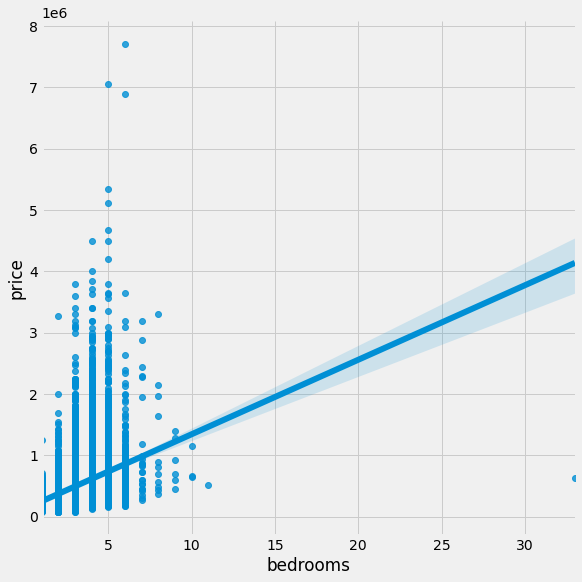

In [104]:
sns.lmplot(data=df_explore, x='bedrooms', y='price', height=8)

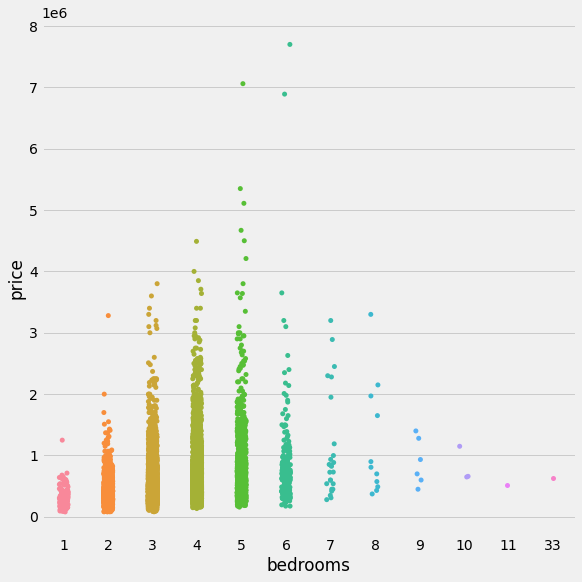

In [105]:
sns.catplot(data=df_explore, x='bedrooms', y='price', height=8)

In [106]:
df_explore.groupby(by='bedrooms')['price'].count()

bedrooms
1      157
2     2184
3     7845
4     5556
5     1280
6      221
7       25
8       11
9        6
10       3
11       1
33       1
Name: price, dtype: int64

catplot

> **Observations:**
> - `sqft_living` shows linearity with `price`
> - `sqft_above` shows linearity with `price`
> - All other columns are non-linear with `price`

## Multicollinearity

I want to check to see if the independent variables are truly independent from each other by checking for multicollinearity.

### Two Variable Multicollinearity Check

<AxesSubplot:>

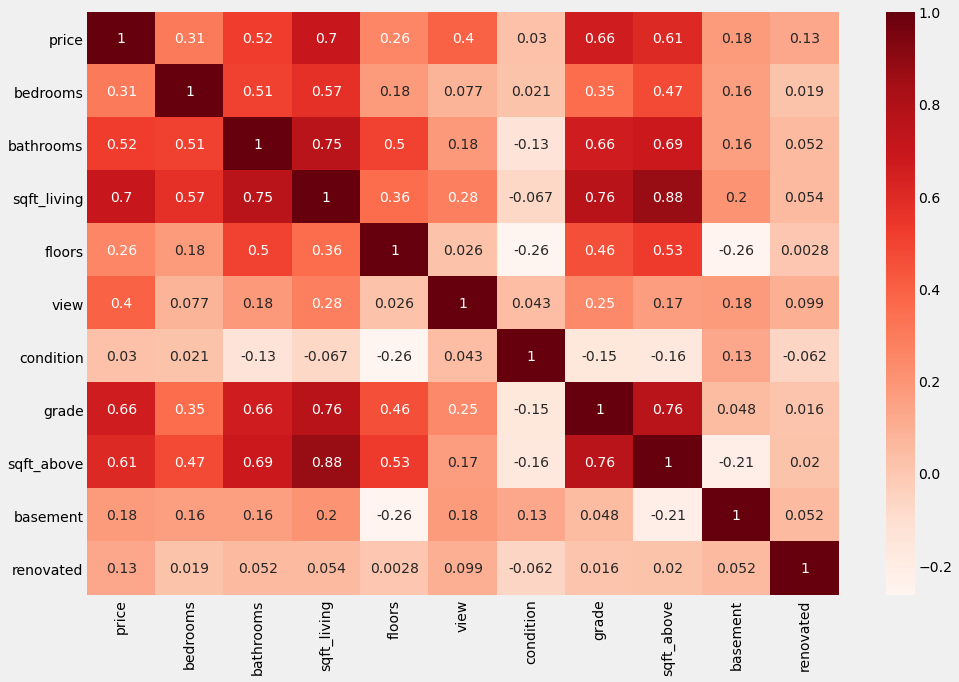

In [108]:
#create and plot correlations
corr = df_explore.corr()
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr, cmap='Reds', annot=True, ax=ax)

> **ACTION: Remove `sqft_above` as it correlates very closesly with `sqft_living`**

In [109]:
#remove sqft_above
df_explore.drop(columns='sqft_above', inplace=True)

<AxesSubplot:>

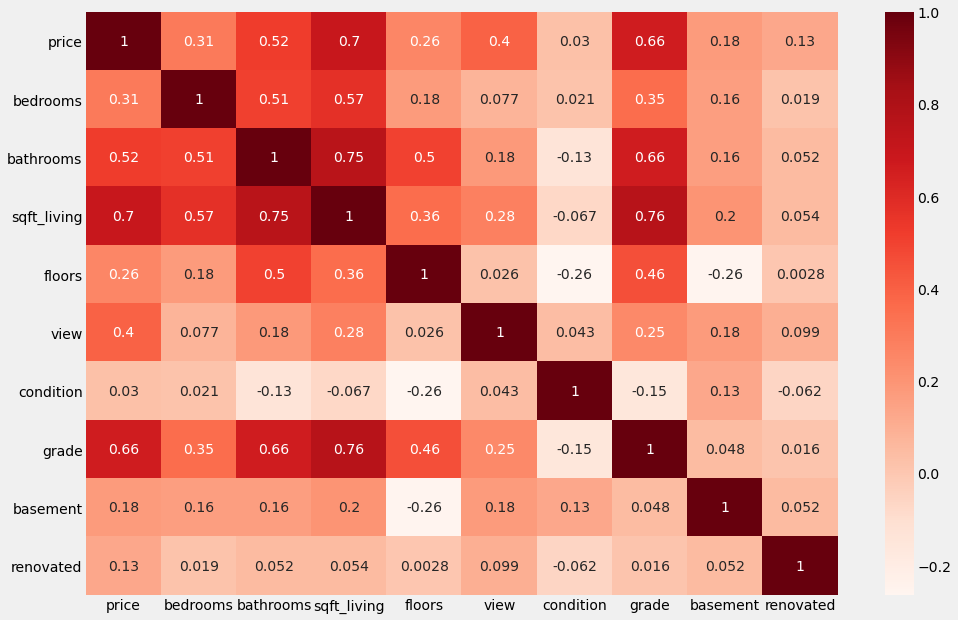

In [110]:
corr = df_explore.corr()
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr, cmap='Reds', annot=True, ax=ax)

> **There are no more variables which correlate above .75, therefore, variables are now considered independent.**

## Exploratory Questions

**if the number of bedrooms/bathrooms or other ordinal and discrete variables has a different effect on the dependent variable price, then OHE those to add variability in the model that may improve it**

In [111]:
df_explore.head()

,price,bedrooms,bathrooms,sqft_living,floors,view,condition,grade,basement,renovated
0,"221,900.0",3,1.0,1180,1.0,0.0,3,7,0,0
1,"538,000.0",3,2.25,2570,2.0,0.0,3,7,1,1
3,"604,000.0",4,3.0,1960,1.0,0.0,5,7,1,0
4,"510,000.0",3,2.0,1680,1.0,0.0,3,8,0,0
5,"1,230,000.0",4,4.5,5420,1.0,0.0,3,11,1,0


### Home Sale Price Over Time

In [112]:
home_sale_sum = pd.Series(df_explore.groupby(by=['yr_sold','month_sold'])['price'].sum())
display(home_sale_sum)
fig, ax = plt.subplots(figsize=(15,10))
home_sale_sum.plot()

KeyError: 'yr_sold'

### Number of Home Sales Over Time

In [113]:
#set index to be datetime column

home_sale_count = pd.Series(df_explore.groupby(by=['yr_sold','month_sold'])['price'].count())
display(home_sale_count)
fig, ax = plt.subplots(figsize=(15,10))
home_sale_count.plot()

KeyError: 'yr_sold'

In [114]:
price_sqft_avg = pd.Series(df_explore.groupby(by=['yr_sold','month_sold'])['price_sqft'].mean())
display(price_sqft_avg)
fig, ax = plt.subplots(figsize=(15,10))
price_sqft_avg.plot()

KeyError: 'yr_sold'

Number of floors and price

home value by age

grade/ by age: are older homes constructed better

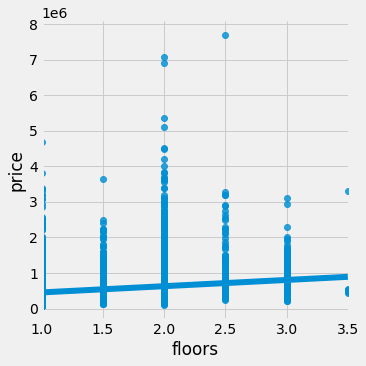

In [115]:
sns.lmplot(x='floors', y='price', data=df_explore)

average sales price by zipcode

average sales price by month_sold

count             17,290.0
mean    541,252.7264314633
std       368,713.27161303
min               80,000.0
25%              322,500.0
50%              450,000.0
75%              645,000.0
max            7,700,000.0
Name: price, dtype: float64

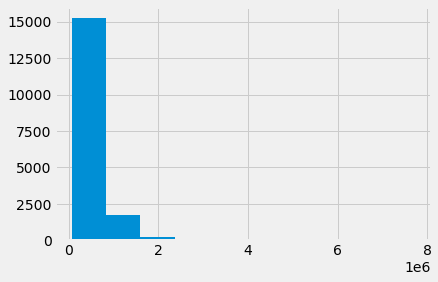

In [116]:
#distribution of home price
plt.hist(x=df_explore['price'])
df_explore['price'].describe()

# Modeling

In [118]:
#create a copy of the explore dataframe
df_model_base = df_explore.copy()
df_model_base

,price,bedrooms,bathrooms,sqft_living,floors,view,condition,grade,basement,renovated
0,"221,900.0",3,1.0,1180,1.0,0.0,3,7,0,0
1,"538,000.0",3,2.25,2570,2.0,0.0,3,7,1,1
3,"604,000.0",4,3.0,1960,1.0,0.0,5,7,1,0
4,"510,000.0",3,2.0,1680,1.0,0.0,3,8,0,0
5,"1,230,000.0",4,4.5,5420,1.0,0.0,3,11,1,0
...,...,...,...,...,...,...,...,...,...,...
21592,"360,000.0",3,2.5,1530,3.0,0.0,3,8,0,0
21593,"400,000.0",4,2.5,2310,2.0,0.0,3,8,0,0
21594,"402,101.0",2,0.75,1020,2.0,0.0,3,7,0,0
21595,"400,000.0",3,2.5,1600,2.0,0.0,3,8,0,0


## Model Preprocessing

### Column Drop

## Model 1

- The data is now ready for the first model run. So far, I have taken the following steps:
    1. Removed irrelevant columns
    2. Removed some outliers in the raw data
    3. Removed columns due to 2-variable multicollinearity
    

### Model Creation

I will now create the initial model by copying the df_model_original dataframe.

In [119]:
#create a new model dataframe
df_model_1 = df_model_base.copy()
df_model_1

,price,bedrooms,bathrooms,sqft_living,floors,view,condition,grade,basement,renovated
0,"221,900.0",3,1.0,1180,1.0,0.0,3,7,0,0
1,"538,000.0",3,2.25,2570,2.0,0.0,3,7,1,1
3,"604,000.0",4,3.0,1960,1.0,0.0,5,7,1,0
4,"510,000.0",3,2.0,1680,1.0,0.0,3,8,0,0
5,"1,230,000.0",4,4.5,5420,1.0,0.0,3,11,1,0
...,...,...,...,...,...,...,...,...,...,...
21592,"360,000.0",3,2.5,1530,3.0,0.0,3,8,0,0
21593,"400,000.0",4,2.5,2310,2.0,0.0,3,8,0,0
21594,"402,101.0",2,0.75,1020,2.0,0.0,3,7,0,0
21595,"400,000.0",3,2.5,1600,2.0,0.0,3,8,0,0


,price,bedrooms,bathrooms,sqft_living,floors,view,condition,grade,basement,renovated
0,"221,900.0",-0.40536846218294575,-1.4621680689633378,-0.9866290943072996,-0.9221740350889067,-0.3044908627691201,-0.6301752898039434,-0.5671325260032586,-0.8045226968997029,-0.2084454571243471
1,"538,000.0",-0.40536846218294575,0.16667103162272143,0.5270395591378295,0.9357132949841763,-0.3044908627691201,-0.6301752898039434,-0.5671325260032586,1.2429011225580338,4.7971405896533765
3,"604,000.0",0.6677934902199218,1.143974491974357,-0.13723229597118397,-0.9221740350889067,-0.3044908627691201,2.4355902590734293,-0.5671325260032586,1.2429011225580338,-0.2084454571243471
4,"510,000.0",-0.40536846218294575,-0.1590967884944904,-0.442143967168764,-0.9221740350889067,-0.3044908627691201,-0.6301752898039434,0.2862809965899825,-0.8045226968997029,-0.2084454571243471
5,"1,230,000.0",0.6677934902199218,3.098581412677628,3.630604783827483,-0.9221740350889067,-0.3044908627691201,-0.6301752898039434,2.8465215643697057,1.2429011225580338,-0.2084454571243471




                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     2830.
Date:                Thu, 15 Apr 2021   Prob (F-statistic):               0.00
Time:                        00:23:49   Log-Likelihood:            -2.3832e+05
No. Observations:               17290   AIC:                         4.767e+05
Df Residuals:                   17280   BIC:                         4.767e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    5.413e+05   1783.237    303.523    

[('bedrooms', 1.6117748712868787),
 ('bathrooms', 2.9477672050176986),
 ('sqft_living', 4.051530337796562),
 ('floors', 1.7178854050365802),
 ('view', 1.1410709978148308),
 ('condition', 1.1007122258213897),
 ('grade', 2.839252612712031),
 ('basement', 1.2697184294015138),
 ('renovated', 1.019881520910346)]



Normality Test Results


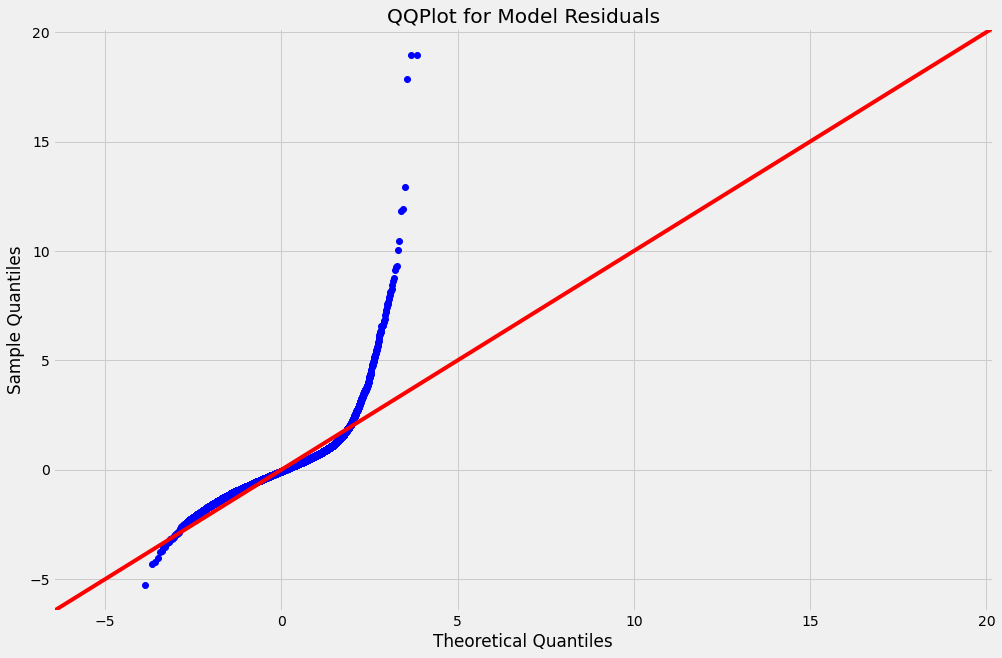



Homoscedasticity Test Results


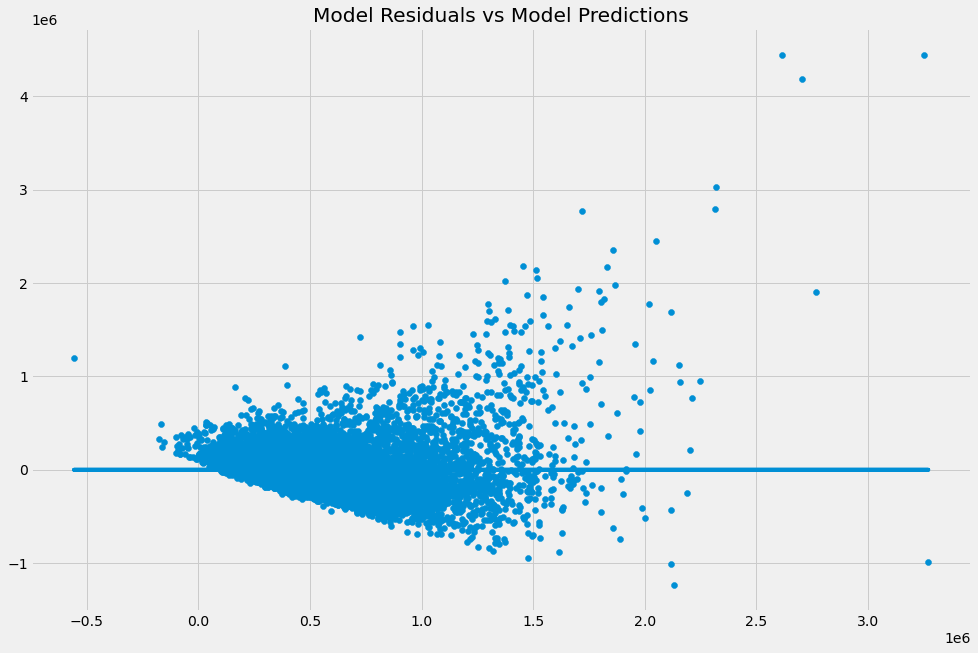

In [120]:
#define indpendent and dependent variables
x_cols = df_model_1.drop(columns='price').columns
y_col = 'price'
#run funciton to create model and check assumptions
fit_new_model(df_model_1, x_cols=x_cols, y_col=y_col, norm=True)

>**OBSERVATOINS**
> - Adjusted R-Squared of 0.61
> - All features with significant p-values except for `zipcode`
> - The most positively correlated features to price are `sqft_living`, `grade`, `home_age`  and `view`
> - The most negatively correlated features to price are `bedrooms`, `month_sold` and `sqft_lot`
> - No multicollinearity found
> - Residuals not normal on the high end of the distribution
> - I am seeing heteroscedasticity along the bottom edge plus as the price gets higher

> **ACTIONS**
> - I will look at OHE `zipcode`

exog function with 4 graphs to look at which column is causing homoscedasticity

### Model Tuning

#### Outlier Removal

I will investigate `price` for outliers.

The number of rows removed is 923
count             17,290.0
mean    541,252.7264314633
std       368,713.27161303
min               80,000.0
25%              322,500.0
50%              450,000.0
75%              645,000.0
max            7,700,000.0
Name: price, dtype: float64


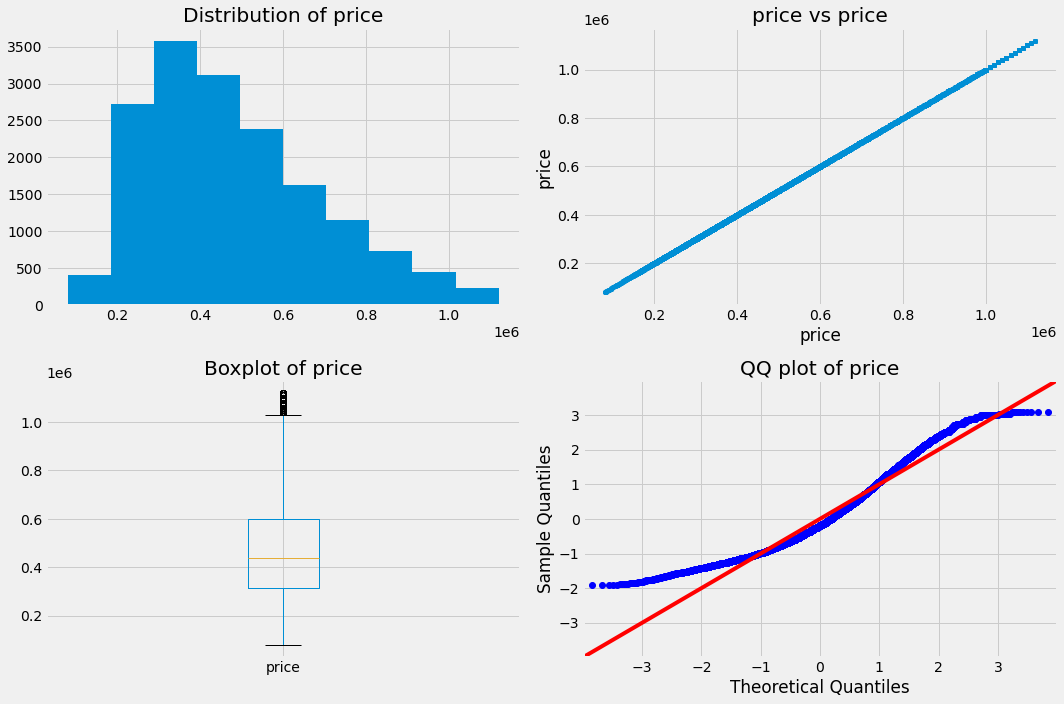

In [122]:
get_plots(df_model_base,'price',outlier='iqr')

> **OBSERVATIONS**
> - I will use iqr to remove outliers because there are a lot of outliers on the high side of `price`. This will be done in the **Outlier Removal** section.

In [123]:
#create a copy of model_2 to set up model_3
df_model_2 = df_model_base.copy()
df_model_2

,price,bedrooms,bathrooms,sqft_living,floors,view,condition,grade,basement,renovated
0,"221,900.0",3,1.0,1180,1.0,0.0,3,7,0,0
1,"538,000.0",3,2.25,2570,2.0,0.0,3,7,1,1
3,"604,000.0",4,3.0,1960,1.0,0.0,5,7,1,0
4,"510,000.0",3,2.0,1680,1.0,0.0,3,8,0,0
5,"1,230,000.0",4,4.5,5420,1.0,0.0,3,11,1,0
...,...,...,...,...,...,...,...,...,...,...
21592,"360,000.0",3,2.5,1530,3.0,0.0,3,8,0,0
21593,"400,000.0",4,2.5,2310,2.0,0.0,3,8,0,0
21594,"402,101.0",2,0.75,1020,2.0,0.0,3,7,0,0
21595,"400,000.0",3,2.5,1600,2.0,0.0,3,8,0,0


In [124]:
#remove outliers based off iqr
df_model_base = outliers(df_model_base, 'price', 'iqr')
df_model_2 = df_model_base.copy()
df_model_2

There were 923 outliers removed.


,price,bedrooms,bathrooms,sqft_living,floors,view,condition,grade,basement,renovated
0,"221,900.0",3,1.0,1180,1.0,0.0,3,7,0,0
1,"538,000.0",3,2.25,2570,2.0,0.0,3,7,1,1
3,"604,000.0",4,3.0,1960,1.0,0.0,5,7,1,0
4,"510,000.0",3,2.0,1680,1.0,0.0,3,8,0,0
8,"229,500.0",3,1.0,1780,1.0,0.0,3,7,1,0
...,...,...,...,...,...,...,...,...,...,...
21592,"360,000.0",3,2.5,1530,3.0,0.0,3,8,0,0
21593,"400,000.0",4,2.5,2310,2.0,0.0,3,8,0,0
21594,"402,101.0",2,0.75,1020,2.0,0.0,3,7,0,0
21595,"400,000.0",3,2.5,1600,2.0,0.0,3,8,0,0


count             16,367.0
mean    477,712.4482189772
std     208,081.3150186878
min               80,000.0
25%              315,000.0
50%              437,718.0
75%              601,000.0
max            1,120,000.0
Name: price, dtype: float64


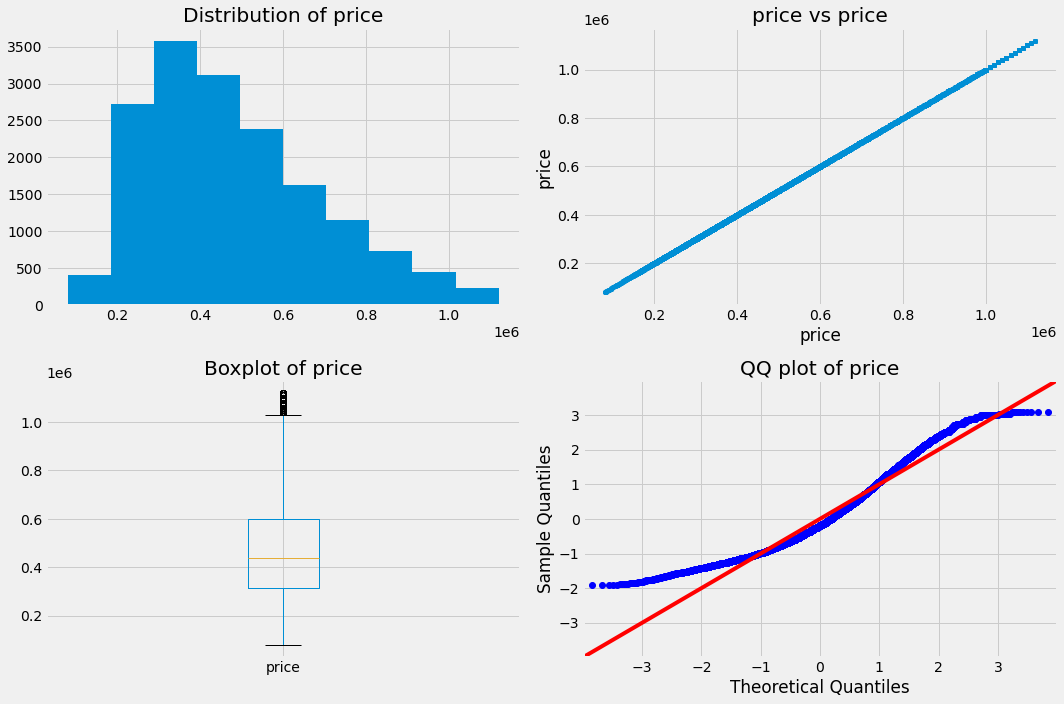

In [126]:
#recheck the price column
get_plots(df_model_2,'price',outlier='none')

## Model 3

In [127]:
#view model_3 dataframe
df_model_2

,price,bedrooms,bathrooms,sqft_living,floors,view,condition,grade,basement,renovated
0,"221,900.0",3,1.0,1180,1.0,0.0,3,7,0,0
1,"538,000.0",3,2.25,2570,2.0,0.0,3,7,1,1
3,"604,000.0",4,3.0,1960,1.0,0.0,5,7,1,0
4,"510,000.0",3,2.0,1680,1.0,0.0,3,8,0,0
8,"229,500.0",3,1.0,1780,1.0,0.0,3,7,1,0
...,...,...,...,...,...,...,...,...,...,...
21592,"360,000.0",3,2.5,1530,3.0,0.0,3,8,0,0
21593,"400,000.0",4,2.5,2310,2.0,0.0,3,8,0,0
21594,"402,101.0",2,0.75,1020,2.0,0.0,3,7,0,0
21595,"400,000.0",3,2.5,1600,2.0,0.0,3,8,0,0


### Model Creation

,price,bedrooms,bathrooms,sqft_living,floors,view,condition,grade,basement,renovated
0,"221,900.0",3,1.0,1180,1.0,0.0,3,7,0,0
1,"538,000.0",3,2.25,2570,2.0,0.0,3,7,1,1
3,"604,000.0",4,3.0,1960,1.0,0.0,5,7,1,0
4,"510,000.0",3,2.0,1680,1.0,0.0,3,8,0,0
8,"229,500.0",3,1.0,1780,1.0,0.0,3,7,1,0




                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     1890.
Date:                Thu, 15 Apr 2021   Prob (F-statistic):               0.00
Time:                        00:26:50   Log-Likelihood:            -2.1782e+05
No. Observations:               16367   AIC:                         4.357e+05
Df Residuals:                   16357   BIC:                         4.357e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.798e+05   1.31e+04    -36.630    

[('bedrooms', 20.91202798198302),
 ('bathrooms', 24.63855915611306),
 ('sqft_living', 21.06025793101637),
 ('floors', 14.831751205008732),
 ('view', 1.1307103784079942),
 ('condition', 20.791129364621387),
 ('grade', 55.35332018952817),
 ('basement', 2.0121633980747156),
 ('renovated', 1.0431499876252417)]



Normality Test Results


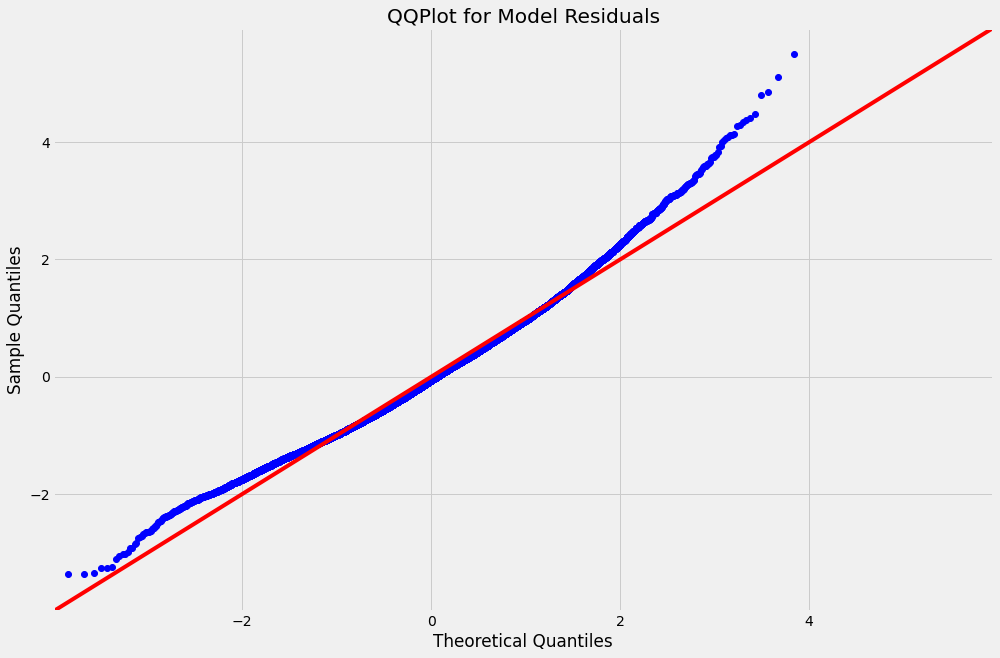



Homoscedasticity Test Results


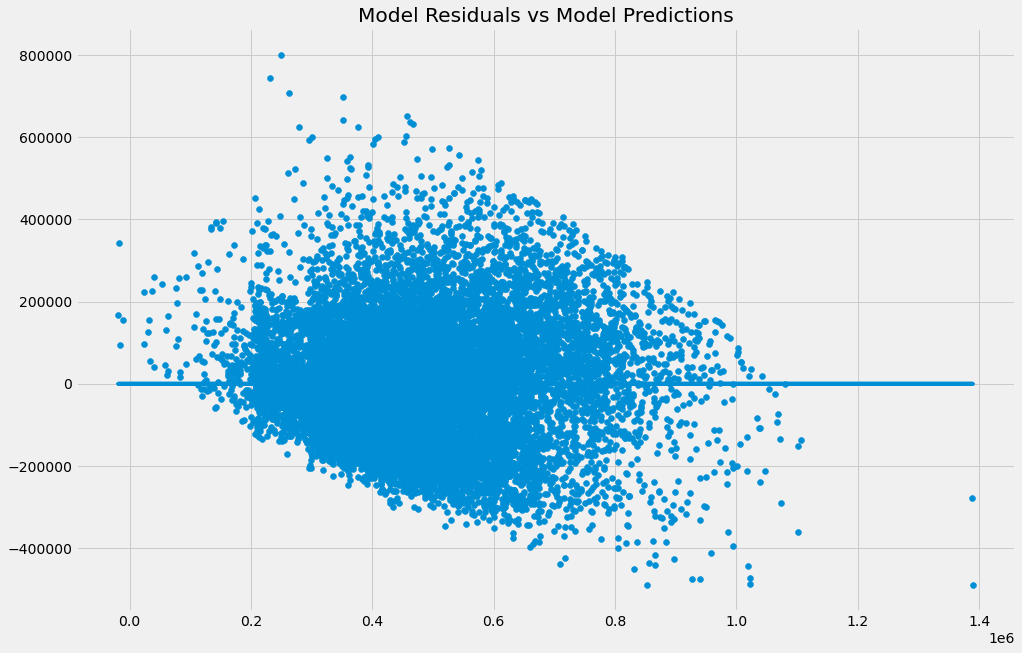

In [132]:
#define indpendent and dependent variables
x_cols = df_model_2.drop(columns='price').columns
y_col = 'price'
#run funciton to create model and check assumptions
model = fit_new_model(df_model_2, x_cols=x_cols, y_col=y_col, norm=False)

In [133]:
model.params

Intercept     -479,812.53507635335
bedrooms       -8,865.516897241305
bathrooms      -24,258.75283663202
sqft_living      95.86005369747792
floors         28,882.699253008544
view           35,012.826546580916
condition       42,713.77303757765
grade            83,956.3254890003
basement        42,974.95982190153
renovated      100,967.40762969966
dtype: float64

In [ ]:
#define indpendent and dependent variables
x_cols = df_model_3.drop(columns='price').columns
y_col = 'price'
#run funciton to create model and check assumptions
fit_new_model(df_model_3, x_cols=x_cols, y_col=y_col, norm=True)

>**OBSERVATIONS**
> - Adjusted R-Squared is now 0.837
> - All features with a significant p-value except for some zipcodes
> - Majority of zipcodes with significant p-values so I will keep them in
> - Coefficients of features are smaller in absolute than they were in model 2. I believe this is because of removing outliers in pricing
> - The distribution of the residuals is more normal
> - The variance in the residuals is more even throughout the prediction of price

> **ACTIONS**
> - Going to look through outliers of all columns and remove extreme values

### Model Tuning

In [ ]:
df_model_base

In [ ]:
get_plots(df_model_base, 'bedrooms', outlier='none')